In [3]:
import duckdb as db
import seaborn as sns
import pandas as pd

In [154]:
conn = db.connect()
conn.sql("ATTACH 'dbname=equiv_v2 user=postgres password=herdeherde host=127.0.0.1 port=5430' as pg (TYPE POSTGRES, READ_ONLY)")

In [165]:
conn.sql("""
create or replace table acc as
with acc as (
  select
    t1.name LIKE 'dh$%' as dh,
    split_part(t1.name, '$', -1) as metric,
    if(dh, t2.value || 'DH', t2.value) as model_old,
    if(t4.value='16', model_old || 'Patch', model_old) as model,
    mean as acc,
	step / 365 / 10 as epoch,
    t3.value as rel_pos_bias
  from
    pg.checkpoint_sample_metric_float as t1
    join pg.model_parameter_text as t2 on t1.model_id = t2.model_id
    left join pg.model_parameter_text as t3 on t1.model_id = t3.model_id
    and t3.name = 'train_config.model.config.rel_pos_bias'
    left join pg.model_parameter_text as t4 on t1.model_id = t4.model_id
    and t4.name = 'train_config.model.config.patch_size'
  where
    t2.name = 'train_config.model.name' -- and
    -- t4.name = 'train_config.model.config.patch_size'
    --and t3.name = 'train_config.model.config.rel_pos_bias'
)
select
  model,
  metric,
  dh,
  acc,
  epoch,
  rel_pos_bias
from
  acc
where metric like 'acc_%'
""")

In [205]:
conn.sql("SELECT DISTINCT epoch from acc where model='SwinHPPanguPatch'")
#conn.sql("SELECT * from acc where dh=true limit 10")

┌────────────────────┐
│       epoch        │
│       double       │
├────────────────────┤
│  220.1095890410959 │
│ 110.05479452054794 │
└────────────────────┘

In [215]:
conn.sql("""
create or replace table data as
select
  try_cast(
    split_part(split_part(metric, '.', 1), '_', -1) as integer
  ) as pressure,
  try_cast(trim(split_part(metric, '.', 2), 'd') as integer) as days,
  string_split(split_part(metric, '.', 1), '_') [1:3] as metric,  --"min(rmse)" as min_rmse,
  *
from
  acc
where
  (
    model = 'SwinHPPangu'
    and epoch > 101
    and epoch < 111
    and rel_pos_bias='single'
  )
  or (
    model = 'SwinHPPanguPatch'
    and epoch > 101
    and epoch < 111
    and rel_pos_bias='single'
  )
  or (
    model = 'PanguParametrized'
    and epoch > 200
  )
  or (
    model = 'PanguParametrizedDH'
    and epoch >= 200
  )
  or (
    model = 'PanguDH'
    and epoch >= 200
  )
  or (
model = 'Pangu' and epoch > 140)
""")

In [233]:
conn.sql("""
create or replace table uadata as
select
  model,
  metric,
  avg(acc) as acc,
  days
  --rel_pos_bias
from
  data
 where
  pressure > 50
  or pressure is null
group by
  model,
  metric,
  days,
  rel_pos_bias
""")

ParserException: Parser Error: syntax error at or near "group"

In [234]:
df_acc = conn.sql("""
select
  days,
  acc,
    CASE model
   WHEN 'SwinHPPangu' THEN 'BADPEAR'
   WHEN 'SwinHPPanguPatch' THEN 'PEAR'
   WHEN 'PanguParametrized' THEN 'PanguHP'
   WHEN 'PanguParametrizedDH' THEN 'Pangu'
   WHEN 'Pangu' THEN 'PanguLargeHP'
   WHEN 'PanguDH' THEN 'PanguLarge'
   ELSE model
   END as model,
  metric :: varchar as metric
from
  uadata
order by
  metric,
  model,
  days
""").df()

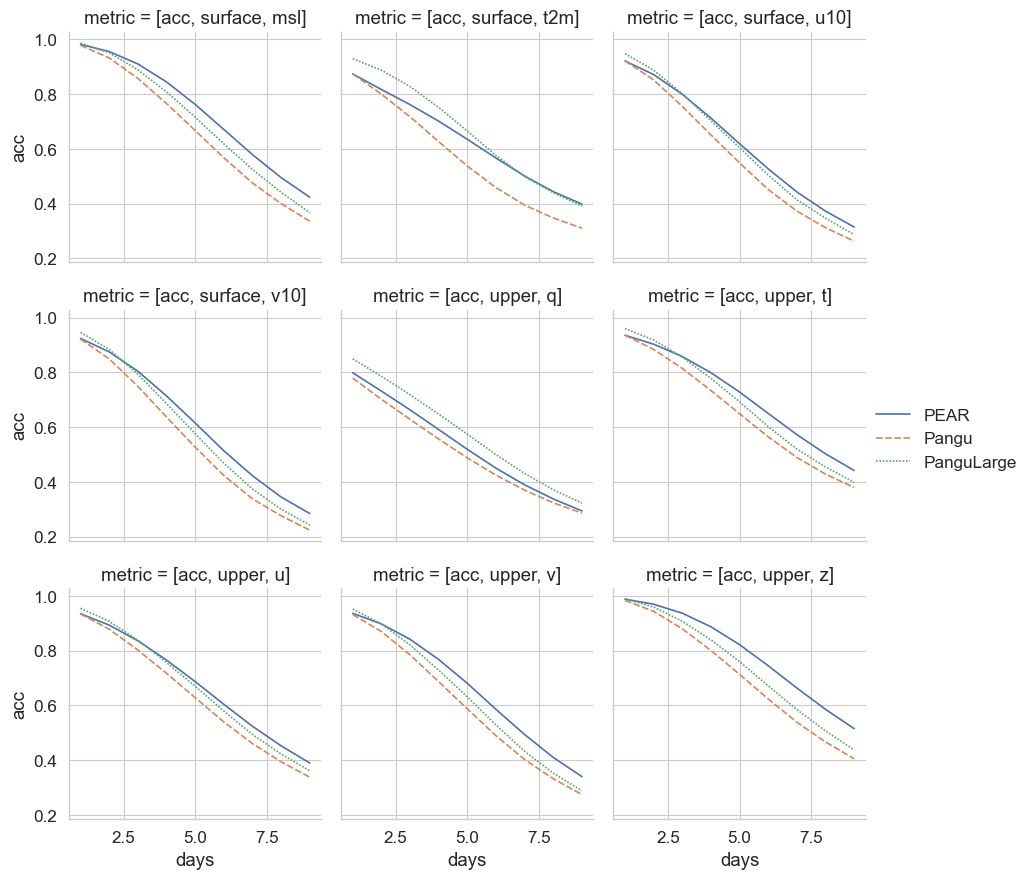

In [235]:
df_acc_plot = df_acc[df_acc["model"].isin(["PEAR", "Pangu", "PanguLarge"])]
sns.set_context("paper", font_scale=1.4)  # use small font scale for LaTeX
sns.set_style("whitegrid")
g = sns.FacetGrid(df_acc_plot, col="metric", sharey=True, col_wrap=3)
g.map_dataframe(sns.lineplot, x="days", y="acc", style="model", hue="model")
g.add_legend()
g.savefig('acc_iterated.pdf')

/var/folders/13/jsy8t1vs0bxb081m6xpgt0nw0000gn/T/ipykernel_15719/3239032478.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_acc_plot[(df_acc["metric"] == "[acc, surface, v10]")


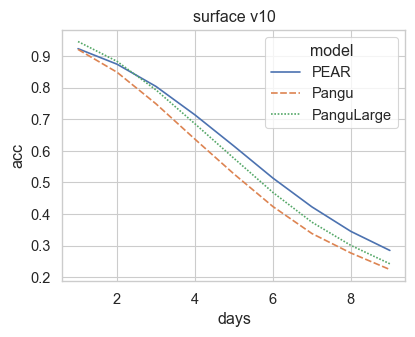

In [231]:
import matplotlib.pyplot as plt
sns.set_context("paper", font_scale=1.2)  # use small font scale for LaTeX
sns.set_style("whitegrid")
#sns.set(font_scale=1.0, rc={'text.usetex' : False})

fig, ax = plt.subplots(figsize=(4.3, 4.3 * 0.818))
sns.lineplot(
    df_acc_plot[(df_acc["metric"] == "[acc, surface, v10]") 
    ], 
    x="days", 
    y="acc", 
    style="model",
    hue="model",
    ax=ax)
plt.title("surface v10")
plt.tight_layout()
plt.savefig("surface_v10.pdf")

In [174]:
conn.sql("""
create or replace table rmse as
with rmse as (
  select
    t1.name LIKE 'dh$%' as dh,
    split_part(t1.name, '$', -1) as metric,
    -- if(dh, t2.value || 'DH', t2.value) as model,
    if(dh, t2.value || 'DH', t2.value) as model_old,
    if(t4.value='16', model_old || 'Patch', model_old) as model,
    mean as rmse,
	step / 365 / 10 as epoch,
    t3.value as rel_pos_bias
  from
    pg.checkpoint_sample_metric_float as t1
    join pg.model_parameter_text as t2 on t1.model_id = t2.model_id
    left join pg.model_parameter_text as t3 on t1.model_id = t3.model_id
    and t3.name = 'train_config.model.config.rel_pos_bias'
    left join pg.model_parameter_text as t4 on t1.model_id = t4.model_id
    and t4.name = 'train_config.model.config.patch_size'
  where
    t2.name = 'train_config.model.name'
    --and t3.name = 'train_config.model.config.rel_pos_bias'
)
select
  model,
  metric,
  rmse,
  epoch,
  rel_pos_bias
from
  rmse
where
metric like 'rmse%'
""")

In [220]:
conn.sql("""
create or replace table data_rmse as
select
  try_cast(
    split_part(split_part(metric, '.', 1), '_', -1) as integer
  ) as pressure,
  try_cast(trim(split_part(metric, '.', 2), 'd') as integer) as days,
  string_split(split_part(metric, '.', 1), '_') [1:3] as metric,  --"min(rmse)" as min_rmse,
  *
from
  rmse
where
  (
    model = 'SwinHPPangu'
    and epoch > 101
    and epoch < 111
    and rel_pos_bias='single'
  ) or   (
    model = 'SwinHPPanguPatch'
    and epoch > 101
    and epoch < 111
    and rel_pos_bias='single'
  )
  or (
    model = 'PanguParametrizedDH'
    and epoch > 200
  )
  or (
    model = 'PanguDH'
    and epoch > 200
  )
  or (
model = 'Pangu' and epoch > 140)
""")

In [221]:
conn.sql("""
create or replace table uadatarmse as
select
  model,
  metric,
  avg(rmse) as rmse,
  days
  --rel_pos_bias
from
  data_rmse
 where
  pressure > 50
  or pressure is null
group by
  model,
  metric,
  days,
  rel_pos_bias
""")

In [222]:
df_rmse = conn.sql("""
select
  days,
  rmse,
  CASE model
   WHEN 'SwinHPPangu' THEN 'BADPEAR'
   WHEN 'SwinHPPanguPatch' THEN 'PEAR'
   WHEN 'PanguParametrized' THEN 'PanguHP'
   WHEN 'PanguParametrizedDH' THEN 'Pangu'
   WHEN 'Pangu' THEN 'PanguLargeHP'
   WHEN 'PanguDH' THEN 'PanguLarge'
   ELSE model
   END as model,
  metric :: varchar as metric
from
  uadatarmse
order by
  metric,
  model,
  days
""").df()

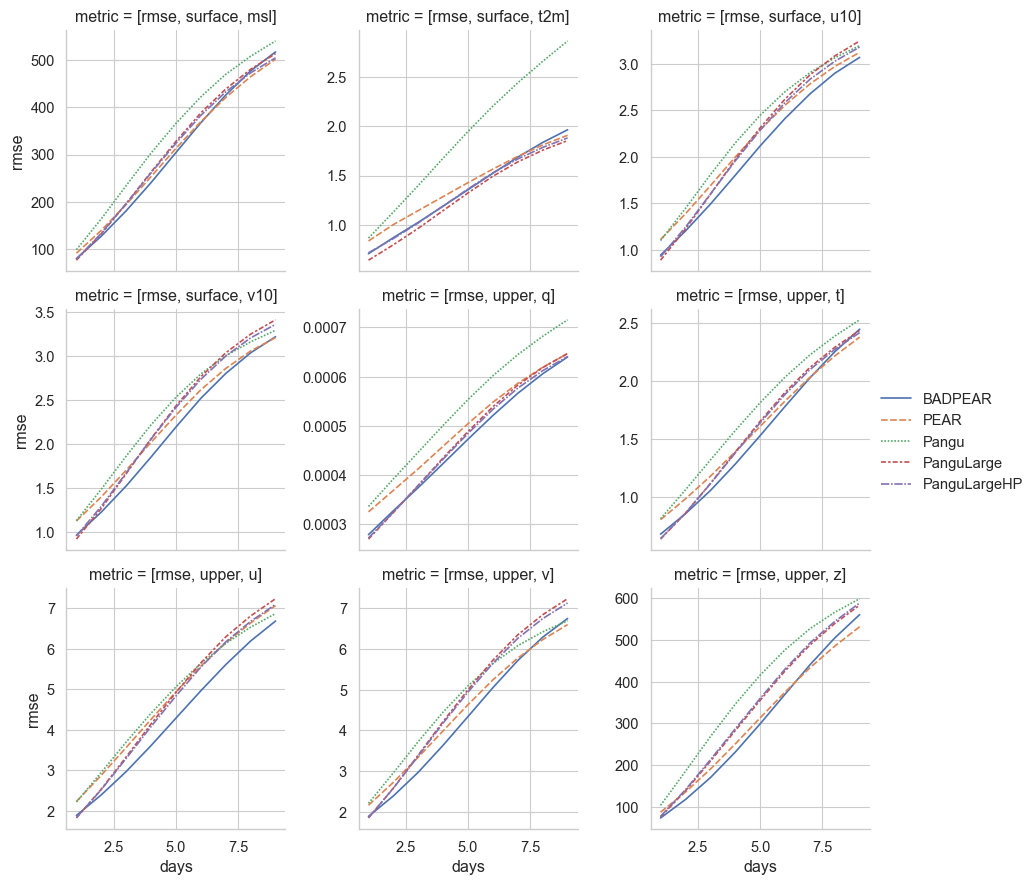

In [223]:
g = sns.FacetGrid(df_rmse, col="metric", sharey=False, col_wrap=3)
g.map_dataframe(sns.lineplot, x="days", y="rmse", style="model", hue="model")
g.add_legend()

In [179]:
df_table_acc = df_acc[(df_acc["days"] == 1) | (df_acc["days"] == 3) | (df_acc["days"] == 5)]
df_table_rmse = df_rmse[(df_rmse["days"] == 1) | (df_rmse["days"] == 3) | (df_rmse["days"] == 5)]

dfacc = df_table_acc.copy()
parts = dfacc['metric'].map(split_metric).apply(pd.Series)
dfacc = pd.concat([dfacc, parts], axis=1)               # add kind, var, lev columns

dfrmse = df_table_rmse.copy()
parts = dfrmse['metric'].map(split_metric).apply(pd.Series)
dfrmse = pd.concat([dfrmse, parts], axis=1)  

#acc  = (dfacc.pivot_table(index=['var','lev','days'],
#                       columns='model', values='acc')
#          .reindex(columns=models))
#rmse = (dfrmse.pivot_table(index=['var','lev','days'],
#                       columns='model', values='rmse')
#           .reindex(columns=models))

In [129]:
import math, numpy as np, pandas as pd

models, main = ['PEAR', 'Pangu'], ['PEAR', 'Pangu']

# ---------- helpers ----------
def var_label(v, l): return fr'$_\mathrm{{{v}}}^\mathrm{{{l}}}$'

def plain_sig(x, sig=3):
    digs = int(math.log10(abs(x))) + 1 if x else 1
    dec  = max(sig - digs, 0)
    s    = f'{x:.{dec}f}'
    return s.rstrip('0').rstrip('.') if '.' in s else s

def fmt(x, bold, is_acc):
    if pd.isna(x): txt = ''
    else:
        e = int(np.floor(np.log10(abs(x)))) if x else 0
        txt = f'{x/10**e:.2g}\\times 10^{{{e}}}' if e < -2 else plain_sig(x,3)
        if is_acc: txt = txt  # same string, kept separate for clarity
    return fr'$\mathbf{{{txt}}}$' if bold else fr'${txt}$'

def split_metric(s):
    k,v,l = [p.strip() for p in s.strip('[]').split(',')]
    return {'kind':k.lower(), 'var':v, 'lev':l}

# ---------- tag rows ----------
for frame in (dfacc, dfrmse):
    frame[['kind','var','lev']] = frame['metric'].map(split_metric).apply(pd.Series)

acc  = (dfacc .pivot_table(index=['var','lev','days'], columns='model', values='acc')
               .reindex(columns=models))
rmse = (dfrmse.pivot_table(index=['var','lev','days'], columns='model', values='rmse')
               .reindex(columns=models))

# ---------- build rows ----------
rows, prev_key = [], None
for (var, lev, day) in acc.index.union(rmse.index):
    acc_vals  = acc .loc[(var, lev, day)] if (var, lev, day) in acc.index  else pd.Series(np.nan, index=models)
    rmse_vals = rmse.loc[(var, lev, day)] if (var, lev, day) in rmse.index else pd.Series(np.nan, index=models)

    bold_acc  = acc_vals .eq(acc_vals [main].max())
    bold_rmse = rmse_vals.eq(rmse_vals[main].min())

    if (var, lev) != prev_key:
        if prev_key is not None: rows.append(r'\midrule')
        prev_key = (var, lev)
        label    = var_label(var, lev)
    else:
        label = ''

    cells = ([fmt(acc_vals [m], bold_acc [m],  True) for m in models] +
             [fmt(rmse_vals[m], bold_rmse[m], False) for m in models])

    rows.append(label + f' & {day} & ' + ' & '.join(cells) + r' \\')

# ---------- LaTeX ----------
bar = '|'
print(r'\begin{tabular}{l r ' + 'r'*3 + bar + 'r'*3 + '}')
print(r'\toprule')
print(r'Variable & Day & \multicolumn{3}{c}{ACC} & \multicolumn{3}{c}{RMSE} \\')
print(r'\cmidrule(lr){3-5}\cmidrule(lr){6-8}')
print(r' & & ' + ' & '.join(models + models) + r' \\')
print(r'\midrule')
print('\n'.join(rows))
print(r'\bottomrule')
print(r'\end{tabular}')


\begin{tabular}{l r rrr|rrr}
\toprule
Variable & Day & \multicolumn{3}{c}{ACC} & \multicolumn{3}{c}{RMSE} \\
\cmidrule(lr){3-5}\cmidrule(lr){6-8}
 & & PEAR & Pangu & PEAR & Pangu \\
\midrule
$_\mathrm{surface}^\mathrm{msl}$ & 1 & $\mathbf{0.99}$ & $0.98$ & $\mathbf{80.4}$ & $$ \\
 & 3 & $\mathbf{0.93}$ & $0.86$ & $\mathbf{181}$ & $$ \\
 & 5 & $\mathbf{0.79}$ & $0.67$ & $\mathbf{304}$ & $$ \\
\midrule
$_\mathrm{surface}^\mathrm{t2m}$ & 1 & $\mathbf{0.91}$ & $0.87$ & $\mathbf{0.71}$ & $$ \\
 & 3 & $\mathbf{0.81}$ & $0.72$ & $\mathbf{1.02}$ & $$ \\
 & 5 & $\mathbf{0.67}$ & $0.54$ & $\mathbf{1.36}$ & $$ \\
\midrule
$_\mathrm{surface}^\mathrm{u10}$ & 1 & $\mathbf{0.94}$ & $0.92$ & $\mathbf{0.94}$ & $$ \\
 & 3 & $\mathbf{0.84}$ & $0.76$ & $\mathbf{1.49}$ & $$ \\
 & 5 & $\mathbf{0.67}$ & $0.55$ & $\mathbf{2.12}$ & $$ \\
\midrule
$_\mathrm{surface}^\mathrm{v10}$ & 1 & $\mathbf{0.94}$ & $0.92$ & $\mathbf{0.97}$ & $$ \\
 & 3 & $\mathbf{0.84}$ & $0.75$ & $\mathbf{1.53}$ & $$ \\
 & 5 & $\mathbf{0.

In [30]:
import math, numpy as np, pandas as pd

models      = ['PEAR', 'Pangu', 'PanguLarge']   # column order
main_models = ['PEAR', 'Pangu']                 # bold-rule base (max/min)

# ── helpers ─────────────────────────────────────────────────────────
def split_metric(s: str):
    k, v, l = [p.strip() for p in s.strip('[]').split(',')]
    return {'kind': k.lower(), 'var': v, 'lev': l}

esc = lambda t: t.replace('_', r'\_').replace('%', r'\%').replace('&', r'\&')

def fmt_acc(x, bold):
    return '' if pd.isna(x) else (rf'$\mathbf{{{x:.1f}}}$' if bold else rf'${x:.1f}$')

def fmt_rmse(x, bold):
    if pd.isna(x): txt = ''
    elif x == 0:   txt = '0'
    else:
        e = int(np.floor(np.log10(abs(x))))
        txt = f'{x/10**e:.2g}\\times 10^{{{e}}}' if e < -2 else f'{x:.3g}'
    return rf'$\mathbf{{{txt}}}$' if bold else rf'${txt}$'

# ── enrich the two data-frames with var/lev columns ─────────────────
for df in (dfacc, dfrmse):
    df[['kind','var','lev']] = df['metric'].map(split_metric).apply(pd.Series)

acc  = (dfacc .pivot_table(index=['var','lev','days'], columns='model', values='acc')
               .reindex(columns=models))
rmse = (dfrmse.pivot_table(index=['var','lev','days'], columns='model', values='rmse')
               .reindex(columns=models))

union_idx = acc.index.union(rmse.index)

# custom sort: surface first, then upper
sort_key = lambda x: (0 if x[0] == 'surface' else 1, x[1], x[2])
union_idx = sorted(union_idx, key=sort_key)

# ── build LaTeX body ─────────────────────────────────────────────────
rows, cur_var, cur_lev = [], None, None
for var, lev, day in union_idx:
    # horizontal rule between variable groups
    if var != cur_var:
        if cur_var is not None:
            rows.append(r'\midrule')
        cur_var, cur_lev = var, None

    # blank lev for subsequent days inside same lev block
    lev_cell = esc(lev) if lev != cur_lev else ''
    cur_lev  = lev

    try:
        acc_row  = acc .loc[(var, lev, day)]
    except KeyError:
        acc_row  = pd.Series(np.nan, index=models)

    try:
        rmse_row = rmse.loc[(var, lev, day)]
    except KeyError:
        rmse_row = pd.Series(np.nan, index=models)

    bold_acc  = acc_row .eq(acc_row [main_models].max())
    bold_rmse = rmse_row.eq(rmse_row[main_models].min())

    cells = ([fmt_acc (acc_row [m],  bool(bold_acc[m]))  for m in models] +
             [fmt_rmse(rmse_row[m], bool(bold_rmse[m])) for m in models])

    rows.append(f'{lev_cell} & {day} & ' + ' & '.join(cells) + r' \\')

# ── emit LaTeX table ─────────────────────────────────────────────────
print(r'\begin{tabular}{l r r r r|r r r}')
print(r'Level & $\Delta t$ & \multicolumn{3}{c}{ACC} & \multicolumn{3}{c}{RMSE} \\')
print(r'\cmidrule(lr){3-5}\cmidrule(lr){6-8}')
print(r' & (days) & PEAR & Pangu & PanguLarge & PEAR & Pangu & PanguLarge \\')
print(r'\midrule')
print('\n'.join(rows))
print(r'\bottomrule')
print(r'\end{tabular}')


\begin{tabular}{l r r r r|r r r}
Level & $\Delta t$ & \multicolumn{3}{c}{ACC} & \multicolumn{3}{c}{RMSE} \\
\cmidrule(lr){3-5}\cmidrule(lr){6-8}
 & (days) & PEAR & Pangu & PanguLarge & PEAR & Pangu & PanguLarge \\
\midrule
msl & 1 & $\mathbf{1.0}$ & $1.0$ & $1.0$ & $\mathbf{80.4}$ & $98.6$ & $79.1$ \\
 & 3 & $\mathbf{0.9}$ & $0.9$ & $0.9$ & $\mathbf{181}$ & $234$ & $196$ \\
 & 5 & $\mathbf{0.8}$ & $0.7$ & $0.7$ & $\mathbf{304}$ & $367$ & $324$ \\
t2m & 1 & $\mathbf{0.9}$ & $0.9$ & $0.9$ & $\mathbf{0.706}$ & $0.891$ & $0.716$ \\
 & 3 & $\mathbf{0.8}$ & $0.7$ & $0.8$ & $\mathbf{1.02}$ & $1.34$ & $1.02$ \\
 & 5 & $\mathbf{0.7}$ & $0.5$ & $0.7$ & $\mathbf{1.36}$ & $1.8$ & $1.36$ \\
u10 & 1 & $\mathbf{0.9}$ & $0.9$ & $0.9$ & $\mathbf{0.945}$ & $1.11$ & $0.926$ \\
 & 3 & $\mathbf{0.8}$ & $0.8$ & $0.8$ & $\mathbf{1.49}$ & $1.83$ & $1.6$ \\
 & 5 & $\mathbf{0.7}$ & $0.6$ & $0.6$ & $\mathbf{2.12}$ & $2.49$ & $2.29$ \\
v10 & 1 & $\mathbf{0.9}$ & $0.9$ & $0.9$ & $\mathbf{0.969}$ & $1.15$ & $0.96$ 

In [132]:
import math, numpy as np, pandas as pd

models, main = ['PEAR', 'Pangu', 'PanguLarge'], ['PEAR', 'Pangu']

# ---------- helpers ----------
def var_label(v, l): return fr'$_\mathrm{{{v}}}^\mathrm{{{l}}}$'

def plain_sig(x, sig=3):
    digs = int(math.log10(abs(x))) + 1 if x else 1
    dec  = max(sig - digs, 0)
    s    = f'{x:.{dec}f}'
    return s.rstrip('0').rstrip('.') if '.' in s else s

def fmt(x, bold, is_acc):
    if pd.isna(x): txt = ''
    else:
        e = int(np.floor(np.log10(abs(x)))) if x else 0
        txt = f'{x/10**e:.2g}\\times 10^{{{e}}}' if e < -2 else plain_sig(x,3)
        if is_acc: txt = txt  # same string, kept separate for clarity
    return fr'$\mathbf{{{txt}}}$' if bold else fr'${txt}$'

def split_metric(s):
    k,v,l = [p.strip() for p in s.strip('[]').split(',')]
    return {'kind':k.lower(), 'var':v, 'lev':l}

# ---------- tag rows ----------
for frame in (dfacc, dfrmse):
    frame[['kind','var','lev']] = frame['metric'].map(split_metric).apply(pd.Series)

acc  = (dfacc .pivot_table(index=['var','lev','days'], columns='model', values='acc')
               .reindex(columns=models))
rmse = (dfrmse.pivot_table(index=['var','lev','days'], columns='model', values='rmse')
               .reindex(columns=models))

# ---------- build rows ----------
rows, prev_key = [], None
for (var, lev, day) in acc.index.union(rmse.index):
    acc_vals  = acc .loc[(var, lev, day)] if (var, lev, day) in acc.index  else pd.Series(np.nan, index=models)
    rmse_vals = rmse.loc[(var, lev, day)] if (var, lev, day) in rmse.index else pd.Series(np.nan, index=models)

    bold_acc  = acc_vals .eq(acc_vals [main].max())
    bold_rmse = rmse_vals.eq(rmse_vals[main].min())

    if (var, lev) != prev_key:
        if prev_key is not None: rows.append(r'\midrule')
        prev_key = (var, lev)
        label    = var_label(var, lev)
    else:
        label = ''

    cells = ([fmt(acc_vals [m], bold_acc [m],  True) for m in models] +
             [fmt(rmse_vals[m], bold_rmse[m], False) for m in models])

    rows.append(label + f' & {day} & ' + ' & '.join(cells) + r' \\')

# ---------- LaTeX ----------
bar = '|'
print(r'\begin{tabular}{l r ' + 'r'*3 + bar + 'r'*3 + '}')
print(r'\toprule')
print(r'Variable & Day & \multicolumn{3}{c}{ACC} & \multicolumn{3}{c}{RMSE} \\')
print(r'\cmidrule(lr){3-5}\cmidrule(lr){6-8}')
print(r' & & ' + ' & '.join(models + models) + r' \\')
print(r'\midrule')
print('\n'.join(rows))
print(r'\bottomrule')
print(r'\end{tabular}')


\begin{tabular}{l r rrr|rrr}
\toprule
Variable & Day & \multicolumn{3}{c}{ACC} & \multicolumn{3}{c}{RMSE} \\
\cmidrule(lr){3-5}\cmidrule(lr){6-8}
 & & PEAR & Pangu & PanguLarge & PEAR & Pangu & PanguLarge \\
\midrule
$_\mathrm{surface}^\mathrm{msl}$ & 1 & $\mathbf{0.99}$ & $0.98$ & $0.99$ & $\mathbf{80.4}$ & $$ & $76.9$ \\
 & 3 & $\mathbf{0.93}$ & $0.86$ & $0.89$ & $\mathbf{181}$ & $$ & $197$ \\
 & 5 & $\mathbf{0.79}$ & $0.67$ & $0.72$ & $\mathbf{304}$ & $$ & $328$ \\
\midrule
$_\mathrm{surface}^\mathrm{t2m}$ & 1 & $\mathbf{0.91}$ & $0.87$ & $0.93$ & $\mathbf{0.71}$ & $$ & $0.64$ \\
 & 3 & $\mathbf{0.81}$ & $0.72$ & $0.83$ & $\mathbf{1.02}$ & $$ & $0.96$ \\
 & 5 & $\mathbf{0.67}$ & $0.54$ & $0.66$ & $\mathbf{1.36}$ & $$ & $1.32$ \\
\midrule
$_\mathrm{surface}^\mathrm{u10}$ & 1 & $\mathbf{0.94}$ & $0.92$ & $0.95$ & $\mathbf{0.94}$ & $$ & $0.89$ \\
 & 3 & $\mathbf{0.84}$ & $0.76$ & $0.8$ & $\mathbf{1.49}$ & $$ & $1.6$ \\
 & 5 & $\mathbf{0.67}$ & $0.55$ & $0.6$ & $\mathbf{2.12}$ & $$ & $2

In [133]:
import math, numpy as np, pandas as pd

models, main = ['PEAR', 'Pangu'], ['PEAR', 'Pangu']

# ---------- helpers ----------
def var_label(v, l): return fr'$_\mathrm{{{v}}}^\mathrm{{{l}}}$'

def plain_sig(x, sig=3):
    digs = int(math.log10(abs(x))) + 1 if x else 1
    dec  = max(sig - digs, 0)
    s    = f'{x:.{dec}f}'
    return s.rstrip('0').rstrip('.') if '.' in s else s

def fmt(x, bold, is_acc):
    if pd.isna(x): txt = ''
    else:
        e = int(np.floor(np.log10(abs(x)))) if x else 0
        txt = f'{x/10**e:.3g}\\times 10^{{{e}}}' if e < -2 else plain_sig(x,3)
        if is_acc: txt = txt  # same string, kept separate for clarity
    return fr'$\mathbf{{{txt}}}$' if bold else fr'${txt}$'

def split_metric(s):
    k,v,l = [p.strip() for p in s.strip('[]').split(',')]
    return {'kind':k.lower(), 'var':v, 'lev':l}

# ---------- tag rows ----------
for frame in (dfacc, dfrmse):
    frame[['kind','var','lev']] = frame['metric'].map(split_metric).apply(pd.Series)

acc  = (dfacc .pivot_table(index=['var','lev','days'], columns='model', values='acc')
               .reindex(columns=models))
rmse = (dfrmse.pivot_table(index=['var','lev','days'], columns='model', values='rmse')
               .reindex(columns=models))

# ---------- build rows ----------
rows, prev_key = [], None
for (var, lev, day) in acc.index.union(rmse.index):
    acc_vals  = acc .loc[(var, lev, day)] if (var, lev, day) in acc.index  else pd.Series(np.nan, index=models)
    rmse_vals = rmse.loc[(var, lev, day)] if (var, lev, day) in rmse.index else pd.Series(np.nan, index=models)

    bold_acc  = acc_vals .eq(acc_vals [main].max())
    bold_rmse = rmse_vals.eq(rmse_vals[main].min())

    if (var, lev) != prev_key:
        if prev_key is not None: rows.append(r'\midrule')
        prev_key = (var, lev)
        label    = var_label(var, lev)
    else:
        label = ''

    cells = ([fmt(acc_vals [m], bold_acc [m],  True) for m in models] +
             [fmt(rmse_vals[m], bold_rmse[m], False) for m in models])

    rows.append(label + f' & {day} & ' + ' & '.join(cells) + r' \\')

# ---------- LaTeX ----------
bar = '|'
print(r'\begin{tabular}{l r ' + 'r'*2 + bar + 'r'*2 + '}')
print(r'\toprule')
print(r'Variable & Day & \multicolumn{3}{c}{ACC} & \multicolumn{3}{c}{RMSE} \\')
print(r'\cmidrule(lr){3-4}\cmidrule(lr){5-6}')
print(r' & & ' + ' & '.join(models + models) + r' \\')
print(r'\midrule')
print('\n'.join(rows))
print(r'\bottomrule')
print(r'\end{tabular}')


\begin{tabular}{l r rr|rr}
\toprule
Variable & Day & \multicolumn{3}{c}{ACC} & \multicolumn{3}{c}{RMSE} \\
\cmidrule(lr){3-4}\cmidrule(lr){5-6}
 & & PEAR & Pangu & PEAR & Pangu \\
\midrule
$_\mathrm{surface}^\mathrm{msl}$ & 1 & $\mathbf{0.99}$ & $0.98$ & $\mathbf{80.4}$ & $$ \\
 & 3 & $\mathbf{0.93}$ & $0.86$ & $\mathbf{181}$ & $$ \\
 & 5 & $\mathbf{0.79}$ & $0.67$ & $\mathbf{304}$ & $$ \\
\midrule
$_\mathrm{surface}^\mathrm{t2m}$ & 1 & $\mathbf{0.91}$ & $0.87$ & $\mathbf{0.71}$ & $$ \\
 & 3 & $\mathbf{0.81}$ & $0.72$ & $\mathbf{1.02}$ & $$ \\
 & 5 & $\mathbf{0.67}$ & $0.54$ & $\mathbf{1.36}$ & $$ \\
\midrule
$_\mathrm{surface}^\mathrm{u10}$ & 1 & $\mathbf{0.94}$ & $0.92$ & $\mathbf{0.94}$ & $$ \\
 & 3 & $\mathbf{0.84}$ & $0.76$ & $\mathbf{1.49}$ & $$ \\
 & 5 & $\mathbf{0.67}$ & $0.55$ & $\mathbf{2.12}$ & $$ \\
\midrule
$_\mathrm{surface}^\mathrm{v10}$ & 1 & $\mathbf{0.94}$ & $0.92$ & $\mathbf{0.97}$ & $$ \\
 & 3 & $\mathbf{0.84}$ & $0.75$ & $\mathbf{1.53}$ & $$ \\
 & 5 & $\mathbf{0.65

In [139]:
import math, numpy as np, pandas as pd

models = ['PEAR', 'Pangu']
main = ['PEAR', 'Pangu']          # drop PanguLarge

# ── helpers ─────────────────────────────────────────────────
def var_label(v, l): return fr'$_\mathrm{{{v}}}^\mathrm{{{l}}}$'

def plain_sig(x, sig=3):
    digs = int(math.log10(abs(x))) + 1 if x else 1
    dec  = max(sig - digs, 0)
    s    = f'{x:.{dec}f}'
    return s.rstrip('0').rstrip('.') if '.' in s else s

def fmt(x, bold, is_acc):
    if pd.isna(x): txt = ''
    else:
        e   = int(np.floor(np.log10(abs(x)))) if x else 0
        txt = f'{x/10**e:.2g}\\times 10^{{{e}}}' if e < -2 else plain_sig(x, 3)
    return fr'$\mathbf{{{txt}}}$' if bold else fr'${txt}$'

def split_metric(s):
    k, v, l = [p.strip() for p in s.strip('[]').split(',')]
    return {'kind': k.lower(), 'var': v, 'lev': l}

# ── tag rows ───────────────────────────────────────────────
for frame in (dfacc, dfrmse):
    frame[['kind', 'var', 'lev']] = frame['metric'].map(split_metric).apply(pd.Series)

acc  = (dfacc .pivot_table(index=['var', 'lev', 'days'], columns='model', values='acc')
               .reindex(columns=models))
rmse = (dfrmse.pivot_table(index=['var', 'lev', 'days'], columns='model', values='rmse')
               .reindex(columns=models))

# ── build rows ─────────────────────────────────────────────
rows, prev_key = [], None
for (var, lev, day) in acc.index.union(rmse.index):
    acc_vals  = acc .loc[(var, lev, day)] if (var, lev, day) in acc.index  else pd.Series(np.nan, index=models)
    rmse_vals = rmse.loc[(var, lev, day)] if (var, lev, day) in rmse.index else pd.Series(np.nan, index=models)

    bold_acc  = acc_vals .eq(acc_vals [main].max())
    bold_rmse = rmse_vals.eq(rmse_vals[main].min())

    label = var_label(var, lev) if (var, lev) != prev_key else ''
    if label and prev_key is not None:
        rows.append(r'\midrule')
    prev_key = (var, lev)

    cells = ([fmt(acc_vals [m], bold_acc [m],  True) for m in models] +
             [fmt(rmse_vals[m], bold_rmse[m], False) for m in models])

    rows.append(label + f' & {day} & ' + ' & '.join(cells) + r' \\')

# ── LaTeX ──────────────────────────────────────────────────
print(r'\begin{tabular}{l r r r|r r}')
print(r'\toprule')
print(r'Variable & $\Delta t$ & \multicolumn{2}{c}{ACC} & \multicolumn{2}{c}{RMSE} \\')
print(r'\cmidrule(lr){3-4}\cmidrule(lr){5-6}')
print(r' & (days) & PEAR & Pangu & PEAR & Pangu \\')
print(r'\midrule')
print('\n'.join(rows))
print(r'\bottomrule')
print(r'\end{tabular}')


\begin{tabular}{l r r r|r r}
\toprule
Variable & $\Delta t$ & \multicolumn{2}{c}{ACC} & \multicolumn{2}{c}{RMSE} \\
\cmidrule(lr){3-4}\cmidrule(lr){5-6}
 & (days) & PEAR & Pangu & PEAR & Pangu \\
\midrule
$_\mathrm{surface}^\mathrm{msl}$ & 1 & $\mathbf{0.99}$ & $0.98$ & $\mathbf{80.4}$ & $$ \\
 & 3 & $\mathbf{0.93}$ & $0.86$ & $\mathbf{181}$ & $$ \\
 & 5 & $\mathbf{0.79}$ & $0.67$ & $\mathbf{304}$ & $$ \\
\midrule
$_\mathrm{surface}^\mathrm{t2m}$ & 1 & $\mathbf{0.91}$ & $0.87$ & $\mathbf{0.71}$ & $$ \\
 & 3 & $\mathbf{0.81}$ & $0.72$ & $\mathbf{1.02}$ & $$ \\
 & 5 & $\mathbf{0.67}$ & $0.54$ & $\mathbf{1.36}$ & $$ \\
\midrule
$_\mathrm{surface}^\mathrm{u10}$ & 1 & $\mathbf{0.94}$ & $0.92$ & $\mathbf{0.94}$ & $$ \\
 & 3 & $\mathbf{0.84}$ & $0.76$ & $\mathbf{1.49}$ & $$ \\
 & 5 & $\mathbf{0.67}$ & $0.55$ & $\mathbf{2.12}$ & $$ \\
\midrule
$_\mathrm{surface}^\mathrm{v10}$ & 1 & $\mathbf{0.94}$ & $0.92$ & $\mathbf{0.97}$ & $$ \\
 & 3 & $\mathbf{0.84}$ & $0.75$ & $\mathbf{1.53}$ & $$ \\
 & 5

In [144]:
import math, numpy as np, pandas as pd

# keep only these two models everywhere
models = main = ['PEAR', 'Pangu']         

# helpers --------------------------------------------------------------
def plain_sig(x, sig=3):
    digs = int(math.log10(abs(x))) + 1 if x else 1
    dec  = max(sig - digs, 0)
    s    = f'{x:.{dec}f}'
    return s.rstrip('0').rstrip('.') if '.' in s else s

def fmt(x, bold, sci):                    # sci=True → RMSE formatting
    if pd.isna(x): 
        return ''                         # completely empty, no “$$”
    if sci:
        e   = int(np.floor(np.log10(abs(x)))) if x else 0
        txt = f'{x/10**e:.2g}\\times 10^{{{e}}}' if e < -2 else plain_sig(x,3)
    else:
        txt = f'{x:.2f}'
    return rf'$\mathbf{{{txt}}}$' if bold else rf'${txt}$'

def split_metric(s):
    k,v,l = [p.strip() for p in s.strip('[]').split(',')]
    return {'kind':k.lower(), 'var':v, 'lev':l}

# add var & lev columns ------------------------------------------------
for df in (dfacc, dfrmse):
    df[['kind','var','lev']] = df['metric'].map(split_metric).apply(pd.Series)

acc  = (dfacc .pivot_table(index=['var','lev','days'],
                           columns='model', values='acc')
               .reindex(columns=models))

rmse = (dfrmse.pivot_table(index=['var','lev','days'],
                           columns='model', values='rmse')
               .reindex(columns=models))

# build LaTeX rows -----------------------------------------------------
rows, prev_key = [], None
for idx in acc.index.union(rmse.index):
    var, lev, day = idx
    
    # new var-lev block → add horizontal rule
    if (var, lev) != prev_key:
        if prev_key is not None:
            rows.append(r'\midrule')
        prev_key = (var, lev)
        label = fr'$_\mathrm{{{var}}}^\mathrm{{{lev}}}$'
    else:
        label = ''
    
    a = acc .loc[idx] if idx in acc.index  else pd.Series(np.nan, index=models)
    r = rmse.loc[idx] if idx in rmse.index else pd.Series(np.nan, index=models)
    
    bold_a = a.eq(a[main].max())
    bold_r = r.eq(r[main].min())
    
    cells = ([fmt(a[m], bold_a[m], False) for m in models] +
             [fmt(r[m], bold_r[m], True ) for m in models])
    
    rows.append(f'{label} & {day} & ' + ' & '.join(cells) + r' \\')

# LaTeX skeleton -------------------------------------------------------
print(r'\begin{tabular}{l r r r|r r}')
print(r'\toprule')
print(r'Variable & $\Delta t$ & \multicolumn{2}{c}{ACC} & \multicolumn{2}{c}{RMSE} \\')
print(r'\cmidrule(lr){3-4}\cmidrule(lr){5-6}')
print(r' & (days) & PEAR & Pangu & PEAR & Pangu \\')
print(r'\midrule')
print('\n'.join(rows))
print(r'\bottomrule')
print(r'\end{tabular}')


\begin{tabular}{l r r r|r r}
\toprule
Variable & $\Delta t$ & \multicolumn{2}{c}{ACC} & \multicolumn{2}{c}{RMSE} \\
\cmidrule(lr){3-4}\cmidrule(lr){5-6}
 & (days) & PEAR & Pangu & PEAR & Pangu \\
\midrule
$_\mathrm{surface}^\mathrm{msl}$ & 1 & $\mathbf{0.99}$ & $0.98$ & $\mathbf{80.4}$ & $99.1$ \\
 & 3 & $\mathbf{0.93}$ & $0.86$ & $\mathbf{181}$ & $235$ \\
 & 5 & $\mathbf{0.79}$ & $0.67$ & $\mathbf{304}$ & $366$ \\
\midrule
$_\mathrm{surface}^\mathrm{t2m}$ & 1 & $\mathbf{0.91}$ & $0.87$ & $\mathbf{0.71}$ & $0.86$ \\
 & 3 & $\mathbf{0.81}$ & $0.72$ & $\mathbf{1.02}$ & $1.4$ \\
 & 5 & $\mathbf{0.67}$ & $0.54$ & $\mathbf{1.36}$ & $1.95$ \\
\midrule
$_\mathrm{surface}^\mathrm{u10}$ & 1 & $\mathbf{0.94}$ & $0.92$ & $\mathbf{0.94}$ & $1.1$ \\
 & 3 & $\mathbf{0.84}$ & $0.76$ & $\mathbf{1.49}$ & $1.81$ \\
 & 5 & $\mathbf{0.67}$ & $0.55$ & $\mathbf{2.12}$ & $2.45$ \\
\midrule
$_\mathrm{surface}^\mathrm{v10}$ & 1 & $\mathbf{0.94}$ & $0.92$ & $\mathbf{0.97}$ & $1.13$ \\
 & 3 & $\mathbf{0.84}$ & $

In [226]:
import math, numpy as np, pandas as pd

models = main = ['PEAR', 'Pangu']            # only these two columns

# ---------------- units for each variable ------------------------------------
units = {
    'msl':  r'$\mathrm{Pa}$',
    't2m':  r'$\mathrm{K}$',
    'u10':  r'$\frac{\mathrm{m}}{\mathrm{s}}$',
    'v10':  r'$\frac{\mathrm{m}}{\mathrm{s}}$',
    'q':    r'$\frac{\mathrm{g}}{\mathrm{kg}}$',
    't':    r'$\mathrm{K}$',
    'u':    r'$\frac{\mathrm{m}}{\mathrm{s}}$',
    'v':    r'$\frac{\mathrm{m}}{\mathrm{s}}$',
    'z':    r'$\mathrm{gpm}$',
}

# ---------------- small helpers ---------------------------------------------
#plain = lambda x,s=3: f'{x:.{max(s-int(math.log10(abs(x)))-1,0)}f}'.rstrip('0').rstrip('.')
plainold = lambda x,s=3: f'{round(x, 2):.2f}'
plain = lambda x,s=3: f'{x:.3g}'
fmt_acc  = lambda v,b: '' if pd.isna(v) else rf'$\mathbf{{{v:.3f}}}$' if b else rf'${v:.3f}$'
def fmt_rmse(v,b):
    if pd.isna(v): return ''
    e=int(np.floor(np.log10(abs(v)))) if v else 0
    txt=f'{v/10**e:.3g}\\times 10^{{{e}}}' if e<-2 else plain(v)
    return rf'$\mathbf{{{txt}}}$' if b else rf'${txt}$'

def split_metric(s):
    k,v,l=[p.strip() for p in s.strip('[]').split(',')]
    return {'kind':k.lower(),'var':v,'lev':l}

# ---------------- enrich dataframes -----------------------------------------
for df in (dfacc, dfrmse):
    df[['kind','var','lev']] = df['metric'].map(split_metric).apply(pd.Series)

acc  = (dfacc .pivot_table(index=['var','lev','days'], columns='model', values='acc')
               .reindex(columns=models))
rmse = (dfrmse.pivot_table(index=['var','lev','days'], columns='model', values='rmse')
               .reindex(columns=models))

# ---------------- build LaTeX body ------------------------------------------
rows = []
for (var, lev), grp in acc.index.union(rmse.index).to_frame(index=False).groupby(['var','lev']):
    days = sorted(set(acc.loc[var, lev].index if (var, lev) in acc.index.droplevel('days')
                      else rmse.loc[var, lev].index))
    unit_cell = rf'\multirow{{{len(days)}}}{{*}}{{{units[lev]}}}'
    for i, day in enumerate(days):
        a = acc .loc[(var, lev, day)] if (var, lev, day) in acc.index  else pd.Series(np.nan, index=models)
        r = rmse.loc[(var, lev, day)] if (var, lev, day) in rmse.index else pd.Series(np.nan, index=models)
        bold_a = a.eq(a[main].max())
        bold_r = r.eq(r[main].min())

        label   = fr'$_\mathrm{{{var}}}^\mathrm{{{lev}}}$' if i == 0 else ''
        unit_col= unit_cell if i == 0 else ''

        rows.append(
            f'{label} & {day} & '
            + ' & '.join([fmt_acc(a[m], bold_a[m]) for m in models]
                         + [fmt_rmse(r[m], bold_r[m]) for m in models])
            + f' & {unit_col} \\\\'
        )
    rows.append(r'\midrule')          # separator after each var/lev block
rows.pop()                            # remove last extra midrule

# ---------------- LaTeX table skeleton --------------------------------------
print(r'\begin{tabular}{l r r r|r r l}')
print(r'\toprule')
print(r'Variable & $\Delta t$ & \multicolumn{2}{c}{ACC} & \multicolumn{2}{c}{RMSE} & unit \\')
print(r'\cmidrule(lr){3-4}\cmidrule(lr){5-6}')
print(r' & (days) & PEAR & Pangu & PEAR & Pangu & \\')
print(r'\midrule')
print('\n'.join(rows))
print(r'\bottomrule')
print(r'\end{tabular}')


\begin{tabular}{l r r r|r r l}
\toprule
Variable & $\Delta t$ & \multicolumn{2}{c}{ACC} & \multicolumn{2}{c}{RMSE} & unit \\
\cmidrule(lr){3-4}\cmidrule(lr){5-6}
 & (days) & PEAR & Pangu & PEAR & Pangu & \\
\midrule
$_\mathrm{surface}^\mathrm{msl}$ & 1 & $\mathbf{0.982}$ & $0.978$ & $\mathbf{91.7}$ & $99.1$ & \multirow{3}{*}{$\mathrm{Pa}$} \\
 & 3 & $\mathbf{0.910}$ & $0.857$ & $\mathbf{195}$ & $235$ &  \\
 & 5 & $\mathbf{0.762}$ & $0.667$ & $\mathbf{313}$ & $366$ &  \\
\midrule
$_\mathrm{surface}^\mathrm{t2m}$ & 1 & $0.873$ & $\mathbf{0.874}$ & $\mathbf{0.836}$ & $0.865$ & \multirow{3}{*}{$\mathrm{K}$} \\
 & 3 & $\mathbf{0.761}$ & $0.717$ & $\mathbf{1.14}$ & $1.4$ &  \\
 & 5 & $\mathbf{0.635}$ & $0.537$ & $\mathbf{1.43}$ & $1.95$ &  \\
\midrule
$_\mathrm{surface}^\mathrm{u10}$ & 1 & $0.921$ & $\mathbf{0.922}$ & $1.11$ & $\mathbf{1.1}$ & \multirow{3}{*}{$\frac{\mathrm{m}}{\mathrm{s}}$} \\
 & 3 & $\mathbf{0.799}$ & $0.755$ & $\mathbf{1.69}$ & $1.81$ &  \\
 & 5 & $\mathbf{0.619}$ & $0.54